# FineDiving
In this notebook, we'll explore the FineDiving dataset characteristics, in terms of:
- **Levels of Annotation**: FineDiving contains 3 levels of annotation from 1) _coarse_ to 2) _fine_, and 3) fine _action quality assessment_ (AQA).
- **Splits**: Train or Test
- **Action Types**: Annotations for the different action types.

In [10]:
%load_ext autoreload
%autoreload 2

import os
import torch

import diveslowlearnfast as dlf
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset

from diveslowlearnfast.config import Config
from diveslowlearnfast.models import SlowFast


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
FINE_DIVING_ROOT = '/Users/youritomassen/Desktop/FineDiving_Dataset'
ANNOTATIONS_ROOT = os.path.join(FINE_DIVING_ROOT, 'Annotations')
SPLITS_ROOT = os.path.join(FINE_DIVING_ROOT, 'train_test_split')
assert os.path.exists(FINE_DIVING_ROOT)

COARSE_ANNOTATIONS = os.path.join(ANNOTATIONS_ROOT, 'FineDiving_coarse_annotation.pkl')
FINE_ANNOTATIONS = os.path.join(ANNOTATIONS_ROOT, 'FineDiving_fine-grained_annotation.pkl')
AQA_ANNOTATIONS = os.path.join(ANNOTATIONS_ROOT, 'fine-grained_annotation_aqa.pkl')
SUB_ACTIONS = os.path.join(ANNOTATIONS_ROOT, 'Sub_action_Types_Table.pkl')
TRAIN_SPLIT = os.path.join(SPLITS_ROOT, 'test_split.pkl')
TEST_SPLIT = os.path.join(SPLITS_ROOT, 'train_split.pkl')
assert os.path.exists(COARSE_ANNOTATIONS)
assert os.path.exists(FINE_ANNOTATIONS)
assert os.path.exists(AQA_ANNOTATIONS)
assert os.path.exists(SUB_ACTIONS)

In [12]:
coarse_dict = pd.read_pickle(COARSE_ANNOTATIONS)
coarse_dict

{('FINAWorldChampionships2019_Men10mSynchronised_final_r4',
  1): {'action_type': '207c', 'start_frame': 3095, 'end_frame': 3195, 'dive_score': 81.18, 'difficulty': 3.3, 'judge_scores': [7.5,
   9.0,
   8.0,
   8.0,
   8.5]},
 ('FINAWorldChampionships2019_Men10mSynchronised_final_r4',
  9): {'action_type': '207b', 'start_frame': 16160, 'end_frame': 16260, 'dive_score': 65.88, 'difficulty': 3.6, 'judge_scores': [4.5,
   5.5,
   7.0,
   7.0,
   6.5]},
 ('FINAWorldChampionships2019_Men10mSynchronised_final_r4',
  10): {'action_type': '207b', 'start_frame': 17690, 'end_frame': 17790, 'dive_score': 97.2, 'difficulty': 3.6, 'judge_scores': [9.0,
   8.5,
   9.0,
   9.5,
   9.0]},
 ('FINAWorldChampionships2019_Men10mSynchronised_final_r4',
  6): {'action_type': '207c', 'start_frame': 11270, 'end_frame': 11370, 'dive_score': 66.33, 'difficulty': 3.3, 'judge_scores': [7.0,
   5.5,
   7.0,
   7.0,
   7.0]},
 ('FINAWorldChampionships2019_Men10mSynchronised_final_r4',
  0): {'action_type': '407c', 

In [13]:
fine_dict = pd.read_pickle(FINE_ANNOTATIONS)
fine_dict

{('01', 1): {'action_type': '407c',
  'dive_score': 88.0,
  'difficulty': 3.2,
  'steps_transit_frames': array([ 2, 34]),
  'frames_labels': array([ 4,  4,  4, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
         25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
         25, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]),
  'sub-action_types': {4: 'Inward', 25: '3.5 Soms.Tuck', 36: 'Entry'}},
 ('01', 2): {'action_type': '407c',
  'dive_score': 86.4,
  'difficulty': 3.2,
  'steps_transit_frames': array([11, 47]),
  'frames_labels': array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 25, 25, 25, 25, 25,
         25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
         25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36,
         36, 36, 36, 36, 36, 36,

In [14]:
actions_dict = pd.read_pickle(SUB_ACTIONS)
actions_dict

{1: 'Forward',
 2: 'Back',
 3: 'Reverse',
 4: 'Inward',
 5: 'Arm.Forward',
 6: 'Arm.Back',
 7: 'Arm.Reverse',
 8: '1 Som.Straight',
 9: '1.5 Soms.Straight',
 10: '2 Soms.Straight',
 11: '2.5 Soms.Straight',
 12: '1 Som.Pike',
 13: '1.5 Soms.Pike',
 14: '2 Soms.Pike',
 15: '2.5 Soms.Pike',
 16: '3 Soms.Pike',
 17: '3.5 Soms.Pike',
 18: '4 Soms.Pike',
 19: '4.5 Soms.Pike',
 20: '1 Som.Tuck',
 21: '1.5 Soms.Tuck',
 22: '2 Soms.Tuck',
 23: '2.5 Soms.Tuck',
 24: '3 Soms.Tuck',
 25: '3.5 Soms.Tuck',
 26: '4 Soms.Tuck',
 27: '4.5 Soms.Tuck',
 28: '5.5 Soms.Tuck',
 29: '0.5 Twist',
 30: '1 Twist',
 31: '1.5 Twists',
 32: '2 Twists',
 33: '2.5 Twists',
 34: '3 Twists',
 35: '3.5 Twists',
 36: 'Entry',
 37: '0.5 Som.Pike',
 38: 'Background',
 39: '0.5 Som.Straight',
 40: '0.5 Som.Tuck',
 41: '4 Twists',
 42: '4.5 Twists'}

In [15]:
test_split = pd.read_pickle(TRAIN_SPLIT)
test_split

[('FINADivingWorldCup2021_Women3m_semifinal_r3', 3),
 ('FINADivingWorldCup2021_Men3m_semifinal_r3', 10),
 ('Budapest2021Diving10mPlatformWomenFinal_2', 5),
 ('07', 11),
 ('01', 120),
 ('26', 89),
 ('FINADivingWorldCup2021_Women10m_final_r4', 0),
 ('06', 23),
 ('Budapest2021Diving10mPlatformWomenFinal_3', 4),
 ('FINADivingWorldCup2021_Women3m_final', 7),
 ('26', 7),
 ('04', 60),
 ('FINAWorldChampionships2019_Women10m_final_r5', 6),
 ('FINADivingWorldCup2021_Men3m_semifinal_r5', 8),
 ('FINAWorldChampionships2019_Women10mSynchronised_final_r3', 6),
 ('FINAWorldChampionships2019_Men3m_final_r6', 7),
 ('FINADivingWorldCup2021_Men10m_final_r1', 3),
 ('02', 56),
 ('01', 66),
 ('3mMenSpringboardFinal-EuropeanChampionships2021_3', 2),
 ('FINAWorldChampionships2019_Women3m_final_r4', 1),
 ('09', 83),
 ('FINADivingWorldCup2021_Women10m_semifinal_r3', 1),
 ('22', 26),
 ('01', 102),
 ('01', 103),
 ('FINADivingWorldCup2021_Women3m_final', 39),
 ('01', 177),
 ('FullMenSynchronised10mPlatform_Tokyo202

In [16]:
from diveslowlearnfast.datasets.fine_diving import FineDivingFineDataset

cfg = Config()
cfg.DATA.DATASET_PATH = FINE_DIVING_ROOT
cfg.DATA.TEST_CROP_SIZE = 224
data = [
    ('Budapest2021Diving10mPlatformWomenFinal_2', 5),
    ('FINADivingWorldCup2021_Men3mSynchronised_final_r1', 9)
]
finediving = FineDivingFineDataset(
    cfg, data=data,
    transform_fn=dlf.get_test_transform(cfg)
)


In [18]:
x, y, *_ = finediving[1]
x.shape, y

(torch.Size([3, 32, 224, 224]),
 tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 37, 37, 37, 37, 37, 37, 37, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 42]))

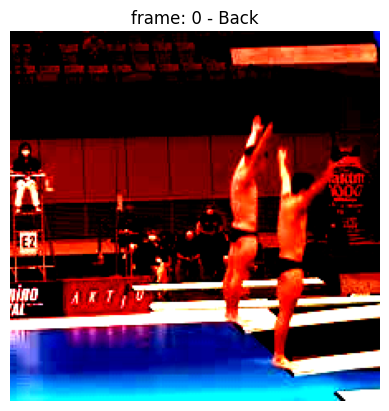

In [19]:
import matplotlib.pyplot as plt

def show_frame(idx):
    plt.imshow(x.permute(1, 2, 3, 0).numpy()[idx])
    plt.title(f'frame: {idx} - {finediving.get_action(y[idx].item())}')
    plt.axis('off')
    plt.show()

show_frame(0)

In [36]:
cfg.FINE_DIVING.ENABLED = True
cfg.MODEL.NUM_CLASSES = 43
cfg.MODEL.DETACH_FINAL_FC = True
model = SlowFast(cfg)
projection = nn.Sequential(
    model.head.projection,
    nn.Linear(cfg.MODEL.NUM_CLASSES, cfg.DATA.NUM_FRAMES * cfg.MODEL.NUM_CLASSES, bias=True),
)
model.head.projection = projection
model

SlowFast(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (pathway1_stem): ResNetBasicStem(
      (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s1_fuse): FuseFastToSlow(
    (conv_f2s): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(8, 1, 1), padding=(3, 0, 0), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [37]:
dataloader = torch.utils.data.DataLoader(finediving, batch_size=2, shuffle=True)
loader_iter = iter(dataloader)

In [38]:
xb, yb, *_ = next(loader_iter)
xb.shape, yb.shape

(torch.Size([2, 3, 32, 224, 224]), torch.Size([2, 32]))

In [39]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
logits = model(inputs)
logits.shape

torch.Size([2, 1376])

In [40]:
batch_size = logits.shape[0]
logits_reshaped = logits.view(-1, 43)  # [B*32, 42]
targets_expanded = yb.view(-1)

logits.shape, targets_expanded.shape, logits_reshaped.shape

(torch.Size([2, 1376]), torch.Size([64]), torch.Size([64, 43]))

In [41]:
yb[0], yb[1]

(tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 37, 37, 37, 37, 37, 37, 37, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 42]),
 tensor([ 6,  6,  6,  6,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 42]))

In [42]:
targets_expanded

tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 37, 37, 37, 37, 37, 37, 37, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 42,  6,  6,  6,  6,
         6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36, 36, 36, 36, 42])

In [50]:
logits.view(2, 32, 43).argmax(dim=-1) == yb

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False]])

In [43]:
F.cross_entropy(logits_reshaped, targets_expanded)

tensor(3.8077, grad_fn=<NllLossBackward0>)

In [16]:
def freeze_weights(model, last_layer_name='projection'):
    for name, param in model.named_parameters():
        if last_layer_name not in name:
            param.requires_grad = False

    return model


model = freeze_weights(model)

list(model.named_parameters())[-1][1].requires_grad

True